In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from invisible_cities.core.fit_functions import gauss
from invisible_cities.core.core_functions import binedges_from_bincenters

from invisible_cities.reco.sensor_functions import charge_fluctuation

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 25
plt.rcParams["lines.linewidth"] = 2

# Charge fluctuation example

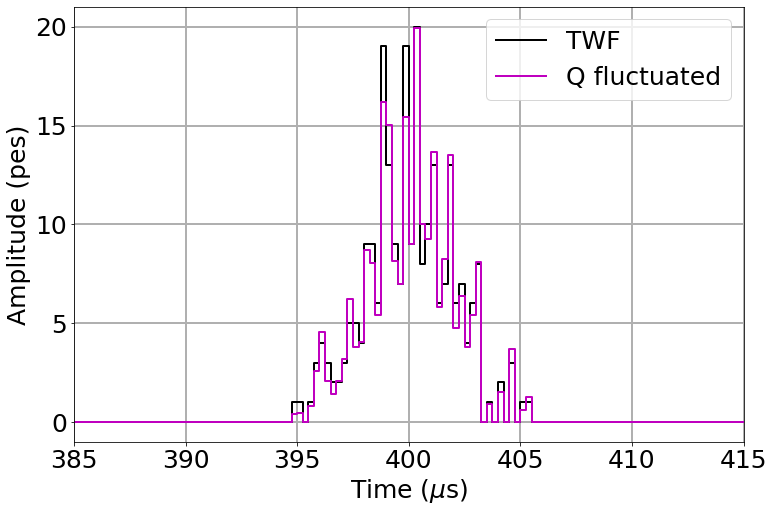

In [31]:
wf = np.zeros(800*4)
t  = np.arange(800*4)/4.
x = np.linspace(-10, 10, 8*40)

np.random.seed(12723)
for ti in 400 + np.random.normal(0, 2, size=250):
    i = np.digitize(ti, t)
    wf[i] += 1

wf2 = np.where(wf > 0, charge_fluctuation(wf, 0.4), 0)

plt.plot(t, wf , "k", drawstyle="steps", label="TWF")
plt.plot(t, wf2, "m", drawstyle="steps", label="Q fluctuated")
plt.xlim(385, 415)
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.grid(lw=2)
plt.legend()
plt.savefig("/home/gonzalo/Escritorio/charge_fluctuation_example.png")

# Noise suppression example

In [3]:
from invisible_cities.database import load_db
from invisible_cities.core.random_sampling import NoiseSampler
from invisible_cities.reco.sensor_functions import simulate_sipm_response
from invisible_cities.reco.wfm_functions    import noise_suppression

def compute_pe_resolution(rms, adc_to_pes):
    return np.divide(rms                              ,
                     adc_to_pes                       ,
                     out   = np.zeros_like(adc_to_pes),
                     where = adc_to_pes != 0          )

In [4]:
detector = "new"
run_number = 8000
wf_length = 800
noise_cut = 1.5

datasipm      = load_db.DataSiPM (detector, run_number)
baselines     = load_db.SiPMNoise(detector, run_number)[-1]
noise_sampler = NoiseSampler(detector, run_number, wf_length, True)

adc_to_pes    = datasipm.adc_to_pes.values
thresholds    = noise_cut * adc_to_pes
single_pe_rms = datasipm.Sigma.values.astype(np.double)
pe_resolution = compute_pe_resolution(single_pe_rms, adc_to_pes)

#def simulate_sipm_response(sipmrd):
#    wfs = sf.simulate_sipm_response(sipmrd, noise_sampler, adc_to_pes, pe_resolution)
#    return wfm.noise_suppression(wfs, thresholds, filter_padding)
#return 

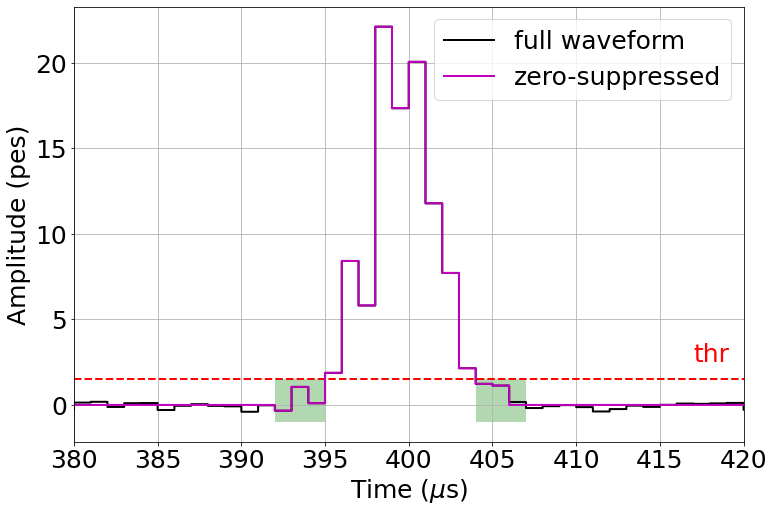

In [33]:
wf = np.zeros(800, dtype=float)
t  = np.arange(len(wf))
np.random.seed(12783)
for ti in 400 + np.random.normal(0, 2, size=100):
    i = np.digitize(ti, t)
    wf[i] += 1

noisy = simulate_sipm_response([wf] * 1792, noise_sampler, adc_to_pes, pe_resolution)
noisy -= baselines[:, np.newaxis]
supp  = noise_suppression(noisy, thresholds, 3)

#plt.plot(t, wf , "k", drawstyle="steps")
plt.plot(t, noisy[0] / adc_to_pes[0], "k", drawstyle="steps", label="full waveform")
plt.plot(t, supp [0] / adc_to_pes[0], "m", drawstyle="steps", label="zero-suppressed")
plt.hlines(1.5, 380, 420, "r", ls="--")
plt.text(417, 2.5, "thr", c="r")
plt.fill_betweenx([-1, 1.5], 392, 395, fc="g", alpha=0.3)
plt.fill_betweenx([-1, 1.5], 404, 407, fc="g", alpha=0.3)
plt.xlim(380, 420)
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.legend()
plt.grid()
plt.savefig("/home/gonzalo/sw/git/sw-docs/docs/source/images/hypathia/noise_suppression.png")

# PSF example

In [7]:
file = "/home/gonzalo/sw/git/IC/invisible_cities/database/test_data/PSF_dst_sum_collapsed.h5"
df = pd.read_hdf(file, "/PSF/PSFs")

In [8]:
df.head()

,xr,yr,zr,x,y,z,factor,nevt
0,-49.5,-49.5,0.0,0.0,0.0,12.5,0.0,3304
1,-49.5,-49.5,0.0,0.0,0.0,37.5,0.0,3672
2,-49.5,-49.5,0.0,0.0,0.0,62.5,0.0,3558
3,-49.5,-49.5,0.0,0.0,0.0,87.5,0.0,3466
4,-49.5,-49.5,0.0,0.0,0.0,112.5,0.0,3516


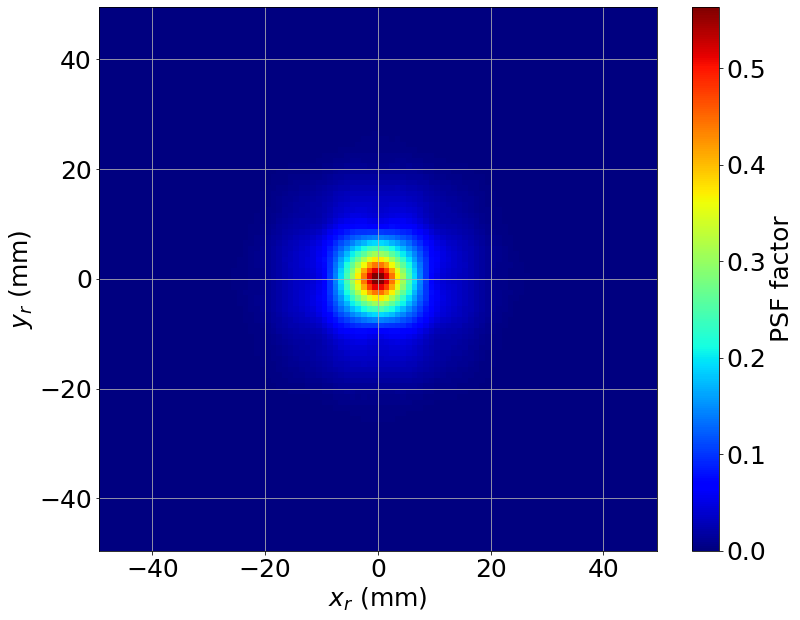

In [34]:
plt.figure(figsize=(12.5, 10))
single = df.loc[lambda df: df.z==12.5]
xbins  = binedges_from_bincenters(single.xr.drop_duplicates().values)
ybins  = binedges_from_bincenters(single.yr.drop_duplicates().values)

plt.hist2d(single.xr, single.yr, (xbins, ybins), weights=single.factor, cmap="jet")
plt.colorbar().set_label("PSF factor")
plt.xlabel("$x_r$ (mm)")
plt.ylabel("$y_r$ (mm)")
plt.grid()
plt.savefig("/home/gonzalo/sw/git/sw-docs/docs/source/images/eutropia/psf_2d.png")

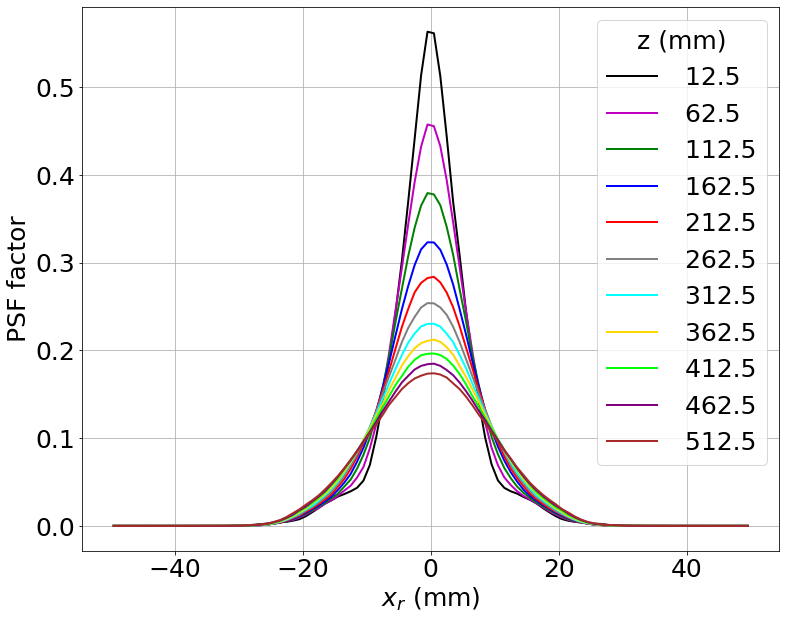

In [31]:
plt.figure(figsize=(12.5, 10))

colors = ("k", "m", "g", "b", "r", "gray", "aqua", "gold", "lime", "purple", "brown", "lawngreen", "tomato", "lightgray", "lightpink")

k = 0
for z, psf in df.loc[lambda df: df.yr==0.5].groupby("z"):
    if (z - 0.5) % 2: continue
    plt.plot(psf.xr, psf.factor, "-", c=colors[k], label=f"{z:> 5.1f}")
    k += 1

plt.xlabel("$x_r$ (mm)")
plt.ylabel("PSF factor")
plt.legend(title = "z (mm)")
plt.grid()
plt.savefig("/home/gonzalo/sw/git/sw-docs/docs/source/images/eutropia/psf_1d.png")